In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Florida
state_ab = "fl"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cong_data = "./{}{}_cong_adopted_2022/P000C0109.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/S027S8058.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/H000H8013.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 8):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision=snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 8):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 8):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|█████████████████████████████████| 390066/390066 [02:31<00:00, 2580.84it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 242.69it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [23]:
start_col = 3
vest_base_data = vest20
year = '20'

In [24]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 219.95it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 67/67 [00:00<00:00, 81.97it/s]


Identifying overlaps...


100%|████████████████████████████████████| 36936/36936 [00:38<00:00, 970.59it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|████████████| 41/41 [00:00<00:00, 100.54it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 1: 100%|███████████████████| 2/2 [00:00<00:00, 32.68it/s]


1 gaps in region 2 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 2: 100%|██████████████| 9/9 [00:00<00:00, 134.74it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 3: 100%|█████████████████| 15/15 [00:00<00:00, 27.32it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 7 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 8: 100%|█████████████████| 11/11 [00:00<00:00, 33.28it/s]


1 gaps in region 9 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 9: 100%|███████████████████| 6/6 [00:00<00:00, 10.75it/s]


1 gaps in region 10 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 12: 100%|██████████████| 2/2 [00:00<00:00, 73.32it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 13 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 13: 100%|██████████████████| 1/1 [00:00<00:00, 30.78it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 15 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 16: 100%|██████████████████| 1/1 [00:00<00:00, 24.19it/s]


1 gaps in region 17 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 20: 100%|████████████████| 11/11 [00:00<00:00, 47.76it/s]


1 gaps in region 21 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 21: 758it [01:11, 10.60it/s]                         
Gaps to fill in region 25: 100%|██████████████████| 8/8 [00:00<00:00, 31.25it/s]


1 gaps in region 26 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 26: 100%|██████████████████| 6/6 [00:00<00:00, 28.61it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 28 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 28: 100%|████████████████| 38/38 [00:01<00:00, 23.96it/s]


1 gaps in region 29 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 29: 100%|████████████████| 14/14 [00:00<00:00, 29.68it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 31 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 31: 100%|███████████| 23/23 [00:00<00:00, 116.02it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 32 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 32: 100%|████████████████| 84/84 [00:01<00:00, 65.02it/s]


1 gaps in region 33 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 34: 100%|████████████████| 60/60 [00:01<00:00, 30.47it/s]


3 gaps in region 35 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 35: 100%|████████████████| 60/60 [00:04<00:00, 13.47it/s]


1 gaps in region 36 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 36: 100%|█████████████| 6/6 [00:00<00:00, 132.94it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 37 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 37: 100%|████████████████| 12/12 [00:00<00:00, 14.22it/s]


1 gaps in region 38 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 39 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 40 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 42: 100%|██████████████████| 8/8 [00:00<00:00, 21.16it/s]


1 gaps in region 43 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 44: 100%|████████████████| 19/19 [00:09<00:00,  1.94it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 46 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 47: 100%|██████████████████| 8/8 [00:00<00:00, 14.81it/s]


1 gaps in region 48 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 48: 100%|██████████████████| 1/1 [00:00<00:00, 43.32it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 52: 100%|██████████████████| 2/2 [00:00<00:00, 17.82it/s]


1 gaps in region 53 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 54: 100%|████████████| 43/43 [00:00<00:00, 98.60it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 55: 100%|████████████████| 41/41 [00:02<00:00, 15.47it/s]


3 gaps in region 56 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 56: 100%|████████████| 16/16 [00:00<00:00, 66.52it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 57 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 57: 100%|██████████████| 2/2 [00:00<00:00, 62.11it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 58 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 59: 100%|██████████████████| 4/4 [00:00<00:00, 34.16it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 61: 100%|██████████| 115/115 [00:01<00:00, 78.81it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 62 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 63: 100%|██████████████████| 7/7 [00:00<00:00, 43.34it/s]


1 gaps in region 64 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 64: 100%|████████████| 64/64 [00:00<00:00, 95.76it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 65 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 65: 100%|████████████| 54/54 [00:00<00:00, 69.36it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [25]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [28]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5, snap_precision=10)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8192/8192 [00:04<00:00, 1640.36it/s]


Resolving overlaps...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1286.93it/s]


There are 4 holes.


Exception: maup.doctor failed

In [ ]:
maup.doctor(vest_base)

## If it is true for maup doctor, we will use it as the base vest data.

In [29]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 6162/6162 [00:21<00:00, 281.31it/s]


In [30]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [31]:
election_df = gpd.GeoDataFrame(vest_base)

In [32]:
election_df.columns

Index(['COUNTY', 'PCT_STD', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [33]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [34]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [35]:
vest18.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G18USSRSCO', 'G18USSDNEL',
       'G18USSOWRI', 'G18GOVRDES', 'G18GOVDGIL', 'G18GOVORIC', 'G18GOVNGIB',
       'G18GOVNFOL', 'G18GOVNSTA', 'G18GOVOWRI', 'G18ATGRMOO', 'G18ATGDSHA',
       'G18ATGNSIS', 'G18CFORPAT', 'G18CFODRIN', 'G18CFOOWRI', 'G18AGRRCAL',
       'G18AGRDFRI', 'geometry'],
      dtype='object')

In [36]:
vest16.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PRECCAS', 'G16PREGSTE', 'G16PREODEL', 'G16PREOWRI',
       'G16USSRRUB', 'G16USSDMUR', 'G16USSLSTA', 'G16USSNKHO', 'G16USSNNAT',
       'G16USSNMAC', 'G16USSNDAL', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [39]:
election_df = smart_repair(election_df, min_rook_length = 30.5, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8199/8199 [00:04<00:00, 1644.82it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 1/1 [00:01<00:00,  1.16s/it]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 982.09it/s]


In [44]:
election_df = smart_repair(election_df, min_rook_length = 30.5, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8194/8194 [00:04<00:00, 1645.15it/s]


Resolving overlaps...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1335.70it/s]


In [45]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1335.47it/s]


There are 4 holes.


False

In [43]:
election_df

,COUNTY,PCT_STD,PRE20D,PRE20O,PRE20R,PRECINCT,geometry,TOTPOP,HISP,NH_WHITE,...,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,BAY,BAY0001,220,15,1330,1,"POLYGON ((68879.777 3376334.096, 68879.193 337...",4062.0,204.0,3447.0,...,90.0,3130.0,131.0,2683.0,26.0,51.0,19.0,0.0,9.0,211.0
1,BAY,BAY0002,132,11,859,2,"POLYGON ((58819.221 3363308.854, 58807.518 336...",1923.0,86.0,1691.0,...,34.0,1547.0,56.0,1387.0,15.0,8.0,3.0,1.0,1.0,76.0
2,BAY,BAY0004,362,33,2130,4,"POLYGON ((70055.737 3361695.181, 69778.679 336...",5282.0,202.0,4665.0,...,74.0,4163.0,151.0,3716.0,57.0,16.0,13.0,1.0,11.0,198.0
3,BAY,BAY0005,324,24,2286,5,"POLYGON ((58819.221 3363308.854, 58803.795 336...",4863.0,230.0,4265.0,...,98.0,3639.0,153.0,3208.0,58.0,22.0,33.0,3.0,3.0,159.0
4,BAY,BAY0006,497,34,2799,6,"POLYGON ((58669.183 3361193.624, 58472.415 336...",5770.0,210.0,5061.0,...,88.0,4579.0,155.0,4059.0,68.0,27.0,32.0,6.0,4.0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6157,OSC,OSC0999,3,0,4,999,"POLYGON ((466692.971 3127956.516, 466662.504 3...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6158,MON,MON0005,1705,52,999,5,"MULTIPOLYGON (((420022.297 2709301.768, 419954...",2408.0,273.0,1909.0,...,136.0,2220.0,215.0,1822.0,84.0,1.0,29.0,1.0,7.0,61.0
6159,MON,MON0999,5,1,10,999,"POLYGON ((418629.172 2715807.767, 418597.168 2...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6160,FLA,FLA0009,1025,23,1569,9,"POLYGON ((478402.651 3255324.547, 478348.409 3...",5091.0,556.0,3661.0,...,200.0,4059.0,396.0,3008.0,395.0,12.0,61.0,1.0,27.0,159.0


In [37]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 6152/6152 [00:05<00:00, 1224.25it/s]


There are 2683 overlaps.
There are 13705 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 26504/26504 [00:15<00:00, 1697.80it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 8658it [2:48:19,  1.17s/it]                                   
100%|█████████████████████████████████████| 6152/6152 [00:04<00:00, 1337.28it/s]


There are 4 holes.


Exception: maup.doctor failed

In [ ]:
election_df.columns

In [ ]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

In [ ]:
election_df = smart_repair(election_df, min_rook_length = min_rook_length, snap_precision=8)

##  Add the district data

In [48]:
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [49]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,2,4296.627441,10,1.0,None,None,18519,15660,184,182,...,14871,1051,13844,13802,1093,1047,42,4,0,"POLYGON ((446932.078 4538628.829, 446520.895 4..."
1,3,16349.305664,11,1.0,None,None,18135,14755,173,246,...,13988,1605,12415,12925,1095,1063,31,1,0,"POLYGON ((408427.491 4583186.510, 407851.148 4..."
2,6,10247.032227,14,1.0,None,None,18189,16225,39,152,...,13672,812,12904,13018,698,684,11,3,0,"POLYGON ((130541.351 4602755.627, 130580.322 4..."
3,13,8422.623047,20,1.0,None,None,17793,15752,39,215,...,13747,829,12950,13003,776,728,41,7,0,"POLYGON ((137848.753 4875017.787, 137875.895 4..."
4,18,2738.210205,25,1.0,None,None,19167,11122,109,6429,...,13960,444,13549,13256,737,678,50,7,2,"POLYGON ((216224.068 4684755.597, 214785.922 4..."


In [50]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 60.82it/s]


In [51]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,6,2704.081055,14,1.0,None,None,9278,7855,102,95,...,7513,425,7097,7013,509,495,13,1,0,"POLYGON ((410634.311 4599884.375, 410644.506 4..."
1,7,2456.038330,15,1.0,None,None,9091,7093,126,165,...,6895,955,5952,6297,610,598,11,1,0,"POLYGON ((340345.876 4699717.968, 340343.687 4..."
2,10,4891.289551,18,1.0,None,None,8886,7900,21,94,...,6648,403,6270,6326,347,338,6,3,0,"POLYGON ((130541.351 4602755.627, 130580.322 4..."
3,13,5355.742676,20,1.0,None,None,9303,8325,18,58,...,7024,409,6634,6692,351,346,5,0,0,"POLYGON ((166456.214 4686976.579, 166297.628 4..."
4,17,3618.739258,24,1.0,None,None,9031,8299,17,52,...,7328,229,7104,7002,331,320,9,2,0,"POLYGON ((178457.059 4938098.060, 178452.973 4..."


In [52]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 92.88it/s]


In [53]:
maup.doctor(election_df)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 640.35it/s]


True

### Put the base precinct year after the precinct information column

In [55]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [56]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'AUD18D', 'AUD18O', 'AUD18R', 'BVAP',
       'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL16D', 'HAL16O',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R',
       'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI',
       'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D',
       'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'STATEFP20', 'TOTPOP', 'TRE18D',
       'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O',
       'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry', 'SEND', 'HDIST'],
      dtype='object')

In [57]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'NAME'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [58]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

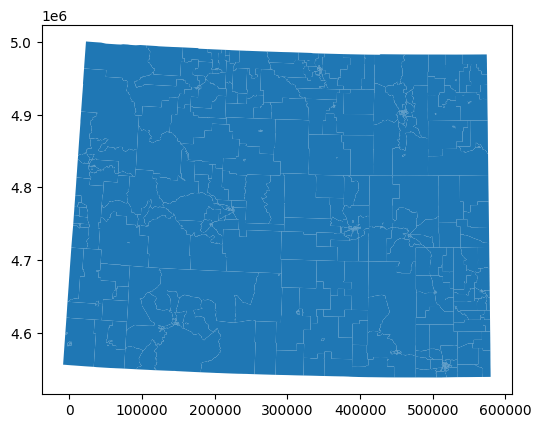

In [59]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()